# TP 4 Regression logistique avec régularisation
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un profuit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from mpl_toolkits import mplot3d


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [46]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(118, 3)

Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [47]:
# rajoutons l'ordonnée à l'origine theta 0
intercept = np.ones((data.shape[0],1))
X_init = np.column_stack((intercept,data[:,0:2]))
y = data[:, 2];
# # forcer y à avoir une seule colonne
# y = y.reshape( y.shape[0], 1)

In [48]:
print('X', X_init.shape ,' y ', y.shape)

X (118, 3)  y  (118,)


# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités

$ \sum_{i = 0}^{p} (i + 1) = p + 1 + \sum_{i = 0}^{p} i $
                         
$...................= p + 1 + \frac{p (p + 1)}{2} $

Pour p = 6, la somme est égale à $ 7 + \frac{6 * 7}{2} = 28 $

In [49]:
def mapping(X):
    
    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j));
            k=k+1
    return outX    


In [50]:
X=mapping(X_init)
X.shape

(118, 28)

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [51]:
def Sigmoid(z):
    return 1/(1+np.exp(-z));
 

In [52]:
k=Sigmoid(-10)
k

4.5397868702434395e-05

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [53]:
def computeCost(X, y, theta, lambdaa):
    # To compute the parameter which we are going to pass to the sigmoid function (an array), in order to compute the response of each data point.
    z = np.sum(theta.transpose() * X, axis=1) 
    # To calculate the response the response of the model for each data point with the given theta values.
    h_theta = Sigmoid(z) 
    # Cost function when the target = 0. (y=0).
    cost_0 = (1-y) * np.log(1-h_theta)
    # Cost function when the target = 1. (y=1).
    cost_1 = y * np.log(h_theta)
    # Full cost function with regularisation.
    j_theta = -np.sum(cost_0 + cost_1)/X.shape[0] + (lambdaa /(2*X.shape[0]) * np.sum(theta[1:]**2))
    return j_theta , h_theta # Return the cost and the responses of the model which will be used later on to calculate the gradient of the cost function.

2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [54]:
def costGradient(X,y,h_theta):
    # This function is used to calculate the partial derivatives of the cost function (gradient with respect to theta_0 and theta_1).
    # Theta_i gradient = (1/m) * sum((Sigma(Xi)-Yi) * Xi) where m is the number of examples and i = 0 ... m.
    # when i = 0, Xi is a vector of ones (the intercept vector) so the formula in this case is equivalent to (1/m) * sum(Sigma(Xi)-Yi).
    gradient = np.array([])
    
    diff = h_theta - y # Sigma(Xi)-Yi => model_responses - target_values : the errors of the model (residuals).
    # Cost Gradient with respect to all of theta_i:
    for k in range(0,X.shape[1]):
        gTheta_i = np.sum(diff * X[:,k]) / X.shape[0] # Theta_i gradient = (1/m) * sum((Sigma(Xi)-Yi) * Xi).
        gradient = np.append(gradient,gTheta_i ) # To add the gradient of theta_i to the array of the other gradients.
    return gradient # Return the cost gradient which will be used to optimize the theta values.
def gradientDescent(X, y, theta, alpha, lambdaa, iterations):
    epsilon = 1e-9
    # The gradient descent is used to optimize theta values (model parameters "intercept and slope").
    modalSettings = np.array([]) # An array which is going to be used to contain the costs.
    # To repeat the steps of gradient descent algorithm until we reach the maximum number of iterations or ....
    for i in range(0,iterations):
        # To compute the cost and the responses of the model with the current theta values.
        cost, h_theta =computeCost(X, y, theta, lambdaa)
        # To save the cost of the current model with its parameters ( theta_i ).
        modalSettings = np.append(modalSettings,theta[:])
        modalSettings = np.append(modalSettings,cost)
        # To calculate the gradient of the cost function with of the current model.
        cost_gradient = costGradient(X,y,h_theta)
        cost_gradient = cost_gradient.reshape(cost_gradient.shape[0],1)
        # To calculate the new theta values ( optimized parameters ).
        # We have separate theta_0 from the other parameters.
        theta[0] = theta[0] - alpha * cost_gradient[0]
        theta[1:] = theta[1:] * (1 - (lambdaa * alpha/X.shape[0])) - alpha * cost_gradient[1:]
        
        # To quit the loop if the gradient is less than epsilon.
        if np.absolute(cost_gradient.mean()) < epsilon:
            break;
    modalSettings = modalSettings.reshape((i+1,theta.shape[0]+1)) # To form a 2D array where each line i contains theta and the cost of the i-th iterration.
    return (theta, modalSettings) # To return the parameters of the model which fits better the dataset and the costs of the different models.

# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [55]:
n=X.shape[1]
theta = np.zeros((n, 1))
# paramètre de regression
lambdaa = 1;

Calculer le cout initial

In [56]:
initialCost, h_theta=computeCost(X, y, theta, lambdaa)
print(initialCost)

0.6931471805599454


Appel des la fonction de calcul du gradient

In [57]:
# paramètres
iterations = 1500;
alpha = 0.2;

# paramètre de regression
lambdaa = 1;

# Appel
theta, modalSettings = gradientDescent(X, y, theta, alpha, lambdaa, iterations);
print(theta)

[[ 1.25310705]
 [ 0.61417154]
 [ 1.16915815]
 [-1.99143035]
 [-0.89083095]
 [-1.38141852]
 [ 0.11961907]
 [-0.36110685]
 [-0.3571215 ]
 [-0.17572614]
 [-1.44827447]
 [-0.06022333]
 [-0.60723613]
 [-0.26647036]
 [-1.18267119]
 [-0.24123841]
 [-0.20716406]
 [-0.05267029]
 [-0.27221632]
 [-0.28983691]
 [-0.47203644]
 [-1.03890318]
 [ 0.01958207]
 [-0.29046852]
 [ 0.00993441]
 [-0.32312667]
 [-0.13857872]
 [-0.93796127]]


Traçage de la fonction du coût

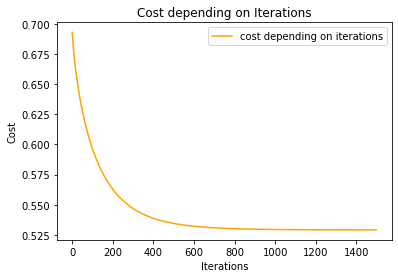

In [58]:
# Cost depending on iterations.
plt.plot(np.array([i for i in range(0,modalSettings.shape[0])]), modalSettings[:,28] ,color='orange', label='cost depending on iterations')
plt.title('Cost depending on Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend(loc='best')

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [59]:
def drawCircle(X, y, theta, title=""):
    x1, x2 = np.meshgrid(np.linspace(X[:, 1].min(), X[:, 1].max(), 100),
                         np.linspace(X[:, 2].min(), X[:, 2].max(), 100))
    Z = (mapping(np.c_[np.ones(x1.size), x1.ravel(), x2.ravel()]) @ theta).reshape(x1.shape)
    print(np.amin(Z), np.amax(Z))

    plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
    plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')
    
    plt.contour(x1, x2, Z, levels=[0], colors= "black", linestyles="dashed")

    plt.xlabel('x 1')
    plt.ylabel('x 2')
    plt.title(title)
    

# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [60]:
def predict(X, y, theta):
    y_pred = np.zeros((X.shape[0], 1))
    y_pred[np.where(Sigmoid(np.sum(theta.transpose() * X, axis=1)) > 0.5)] = 1
    return y_pred


# Affichage 
Graphe representant les acceptations selon les caracteristiques

-14.826406069507895 1.4742156833990794


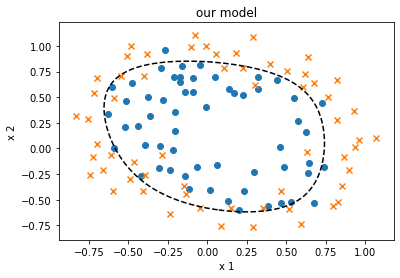

In [61]:
drawCircle(X_init, y, theta, "our model")

Traçage du coût en fonction de theta0 et theta1

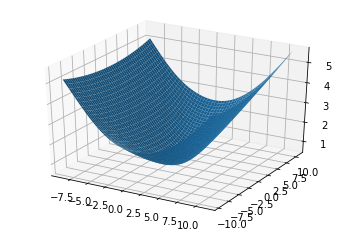

In [62]:
theta_0_range, theta_1_range = np.meshgrid(np.arange(theta[0] - 10, theta[0] + 10, 0.1), 
                                           np.arange(theta[1] - 10, theta[1] + 10, 0.1))
theta_mesh = np.expand_dims(np.stack((theta_0_range, theta_1_range), axis=-1), axis=3)
loss = np.asarray(
    [
        [computeCost(X, y, np.concatenate((theta_mesh[i, j], theta[2:]), axis=0), lambdaa)[0]
             for j in range(theta_mesh.shape[1])
        ] 
        for i in range(theta_mesh.shape[0])
    ]
)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta_0_range, theta_1_range, loss)

# Qualité du classifieur

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [63]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X, y, theta).reshape(y.shape)
precision = np.mean( y == y_pred )*100
precision

83.05084745762711

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn


number of iterations of the sklearn algorithm :  17

=== using our loss
our model error     :  0.46417551282741704
sklearn model error :  0.46246131978037225

=== using sklearn loss
our model error     :  0.46417551282741704
sklearn model error :  0.46246131978037225

Comparing the precision
our model precision     :  83.05084745762711
sklearn model precision :  83.05084745762711
-14.906585165164156 1.4926201404230852
-14.826406069507895 1.4742156833990794


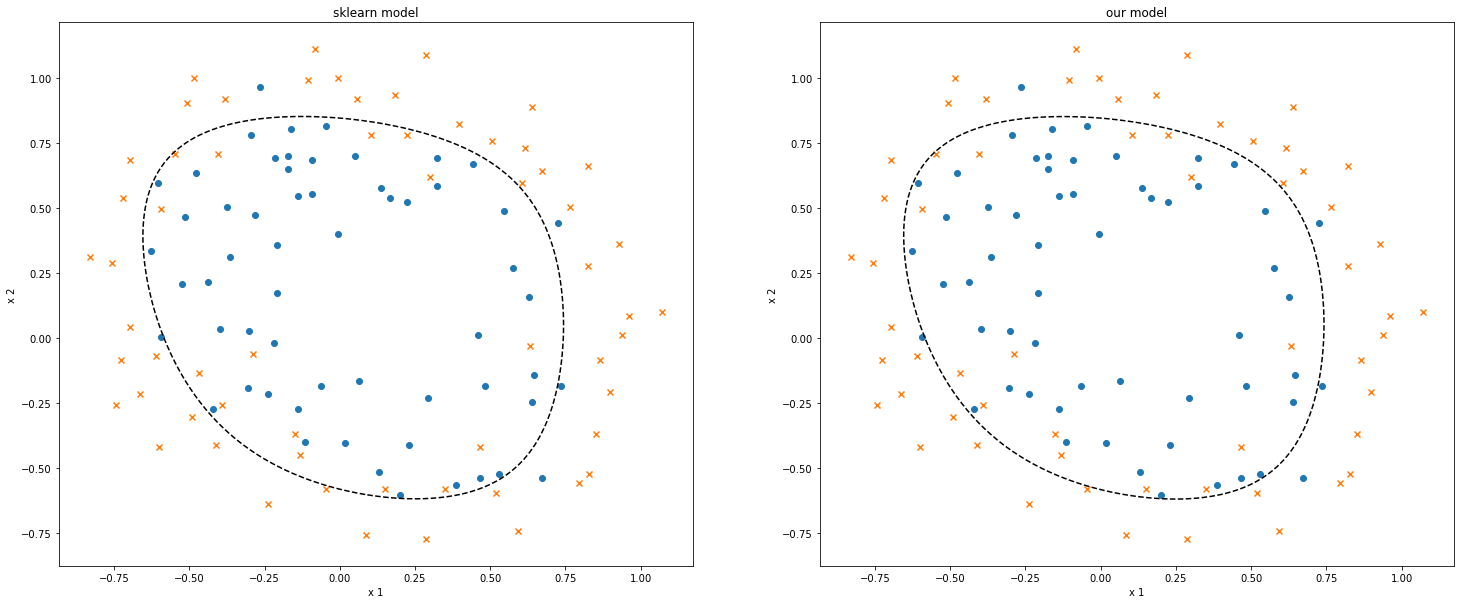

In [64]:
def compare_to_sklearn(X, y, theta):
    sklearn_model = LogisticRegression(penalty='l2')
    sklearn_model.fit(X[:, 1:],y)
    
    theta_sk = np.zeros(theta.shape)
    theta_sk[1:] = sklearn_model.coef_.reshape(-1, 1)
    theta_sk[0] = sklearn_model.intercept_[0]
    theta_sk = np.reshape(theta_sk, (-1, 1))
    
    print("\nnumber of iterations of the sklearn algorithm : ", sklearn_model.n_iter_[0])
    print("\n=== using our loss")
    print("our model error     : ", computeCost(X, y, theta, 0)[0])
    print("sklearn model error : ", computeCost(X, y, theta_sk, 0)[0])
    
    print("\n=== using sklearn loss")
    print("our model error     : ", log_loss(y, Sigmoid(np.sum(theta.transpose() * X, axis=1))))
    print("sklearn model error : ", log_loss(y, Sigmoid(X @ theta_sk)))
    
    print("\nComparing the precision")
    print("our model precision     : ", np.mean(y == predict(X, y, theta_sk).reshape(y.shape))*100)
    print("sklearn model precision : ", np.mean(y.reshape(-1,)==sklearn_model.predict(X[:, 1:]))*100)
    
    plt.figure(figsize=(25, 10))

    plt.subplot(1, 2, 1)
    drawCircle(X_init, y, theta_sk, "sklearn model")

    plt.subplot(1, 2, 2)
    drawCircle(X_init, y, theta, "our model")
    
compare_to_sklearn(X, y, theta)

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

In [65]:
#Standardisation des données

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 01 Avril 2022 à 22h


In [66]:
# bonne chance